In [109]:
setwd("~/Documents/DE/2018/")
require(ggplot2)
require(nlme)
require(multcomp)

In [133]:
d=read.csv("DE2018_alldata.csv")
w=read.csv("Dry_Weight.csv")

In [134]:
#separate treatments
d$Density=ifelse(substr(d$Bucket,1,1)=="L", "Low", "High")
d$Diversity=ifelse(substr(d$Bucket,2,2)=="P", "Poly", "Mono")

In [135]:
#add number of CV 
d$cv_start=ifelse(d$Density=='Low'& d$Diversity=='Mono', 30,
ifelse(d$Density=='Low'& d$Diversity=='Poly', 15,
ifelse(d$Density=='High'& d$Diversity=='Mono', 60, 30
)))

In [136]:
#separate out oysters
cv=d[d$Species=="CV"& !is.na(d$Weight_post)& !is.na(d$Weight),]

In [137]:
## calculate length and weight change
cv$Length_post=as.numeric(as.character(cv$Length_post))
cv$Length_pre=as.numeric(as.character(cv$Length_pre))
cv$Weight_change=cv$Weight_post-cv$Weight
cv$Length_change=cv$Length_post-cv$Length_pre
cv$Width_change=cv$Width_post-cv$Width_pre

In [138]:
#calculate final dry weight
w$dry_weight=w$Final.weight-w$weight
dryw=merge(d, w, by=c("Bucket", "Color.Number", "Species"))

#look to see if there is good enough relationship between dry and wet weight
Dry_results= lm(Weight_post ~ dry_weight, dryw)
summary(Dry_results)
print(Dry_results)


Call:
lm(formula = Weight_post ~ dry_weight, data = dryw)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6659 -1.1238 -0.0527  0.9261  4.0034 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.5773     0.9131   0.632    0.531    
dry_weight   24.7132     2.1960  11.254 1.67e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.981 on 37 degrees of freedom
  (25 observations deleted due to missingness)
Multiple R-squared:  0.7739,	Adjusted R-squared:  0.7678 
F-statistic: 126.6 on 1 and 37 DF,  p-value: 1.666e-13



Call:
lm(formula = Weight_post ~ dry_weight, data = dryw)

Coefficients:
(Intercept)   dry_weight  
     0.5773      24.7132  



ok, R2 value is too low to convert...oh well. 

In [139]:
#funciton to calculate se and average at once
multi = function(x) {
      c(avg = mean(x, na.rm=TRUE), se = sd(x, na.rm=TRUE)/sqrt(length(x)) )
}

# Wet weight change

In [140]:
NROW(cv)

[1] 420

In [144]:
weight=aggregate(Weight_change~Density+Diversity, data=cv, FUN=multi)
weight$avg=weight$Weight_change[,1]
weight$sd=weight$Weight_change[,2]
weight=weight[-3]

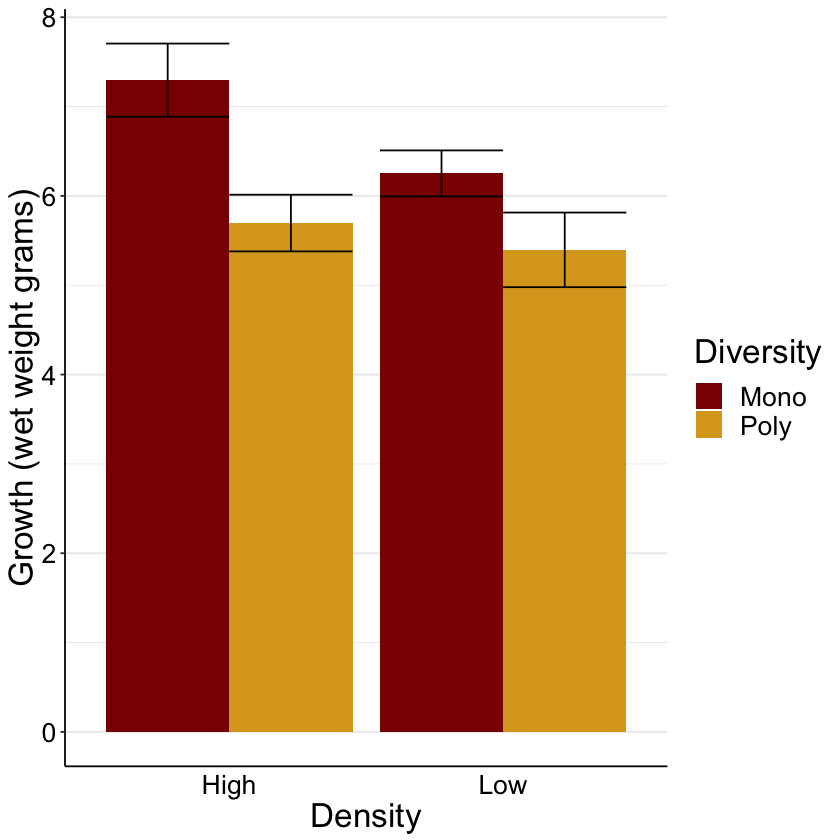

In [145]:
ggplot(weight, aes(x = Density, y = avg, fill=Diversity)) +
scale_fill_manual(values=c("darkred", "goldenrod"))+
        geom_bar(stat="identity", position="dodge")+
 geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), position="dodge") +
theme_bw()+
 theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), axis.text=element_text(color="black"),
          text = element_text(size=20))+
ylab("Growth (wet weight grams)")

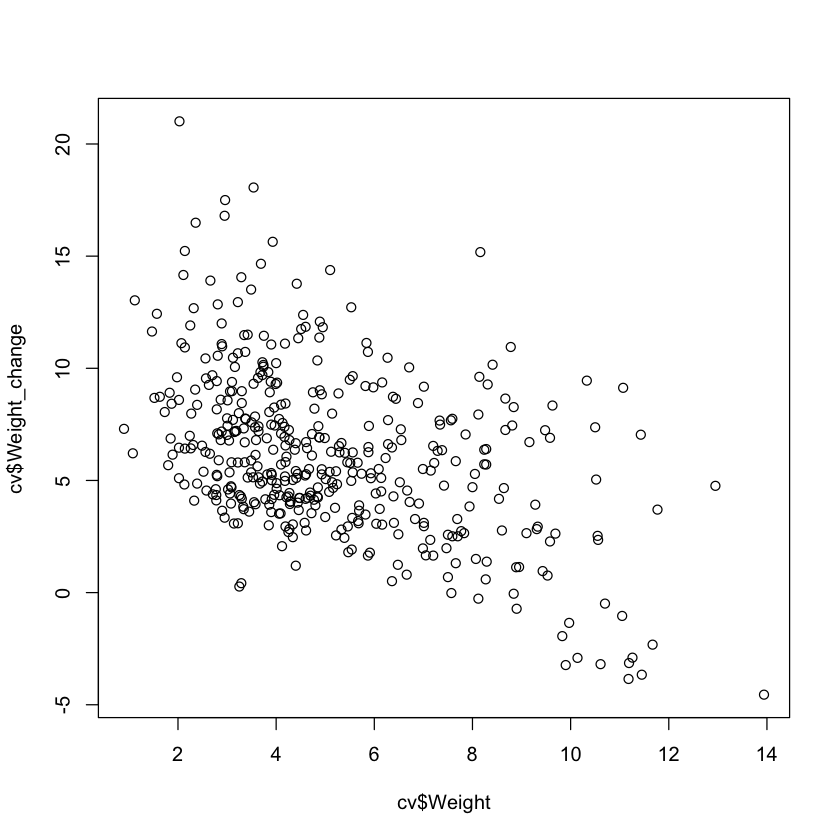

In [147]:
#does change in weight depend on iniital weight?
plot(cv$Weight, cv$Weight_change)

So, smaller oysters grow more. Not surprising, makes sense to include as a covariate

In [ ]:
wc_results= lme(Weight_change ~ Density*Diversity+Weight, random=~1|Bucket, cv, method="REML")
plot(wc_results)
qqnorm(residuals(wc_results))
qqline(residuals(wc_results))

add shell length as a covariate

In [150]:
summary(wc_results)

Linear mixed-effects model fit by REML
 Data: cv 
       AIC      BIC    logLik
  2178.273 2206.471 -1082.137

Random effects:
 Formula: ~1 | Bucket
        (Intercept) Residual
StdDev:   0.7798087 3.115181

Fixed effects: Weight_change ~ Density * Diversity + Weight 
                             Value Std.Error  DF    t-value p-value
(Intercept)              10.874439 0.5243053 384  20.740661  0.0000
DensityLow               -1.529620 0.5769040  31  -2.651429  0.0125
DiversityPoly            -1.414310 0.5640327  31  -2.507497  0.0176
Weight                   -0.713388 0.0669145 384 -10.661188  0.0000
DensityLow:DiversityPoly  1.709258 0.8162968  31   2.093917  0.0445
 Correlation: 
                         (Intr) DnstyL DvrstP Weight
DensityLow               -0.590                     
DiversityPoly            -0.528  0.498              
Weight                   -0.638  0.081 -0.036       
DensityLow:DiversityPoly  0.451 -0.711 -0.686 -0.110

Standardized Within-Group Residuals:
     

So, interaction between density and diversity is significant

In [154]:
cv$DD=interaction(cv$Density, cv$Diversity)
wc_dd= lme(Weight_change ~ DD+Weight, random=~1|Bucket, cv, method="REML")
summary(glht(wc_dd, linfct=mcp(DD="Tukey")))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lme.formula(fixed = Weight_change ~ DD + Weight, data = cv, random = ~1 | 
    Bucket, method = "REML")

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)  
Low.Mono - High.Mono == 0   -1.5296     0.5769  -2.651   0.0401 *
High.Poly - High.Mono == 0  -1.4143     0.5640  -2.507   0.0588 .
Low.Poly - High.Mono == 0   -1.2347     0.5829  -2.118   0.1473  
High.Poly - Low.Mono == 0    0.1153     0.5718   0.202   0.9971  
Low.Poly - Low.Mono == 0     0.2949     0.5938   0.497   0.9598  
Low.Poly - High.Poly == 0    0.1796     0.5740   0.313   0.9894  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


# Weight change by number of oysters

In [155]:
#thirty=cv[cv$cv_start==30,]
weight=aggregate(Weight_change~cv_start+Diversity, data=cv, FUN=multi)
weight$avg=weight$Weight_change[,1]
weight$sd=weight$Weight_change[,2]
weight=weight[-3]

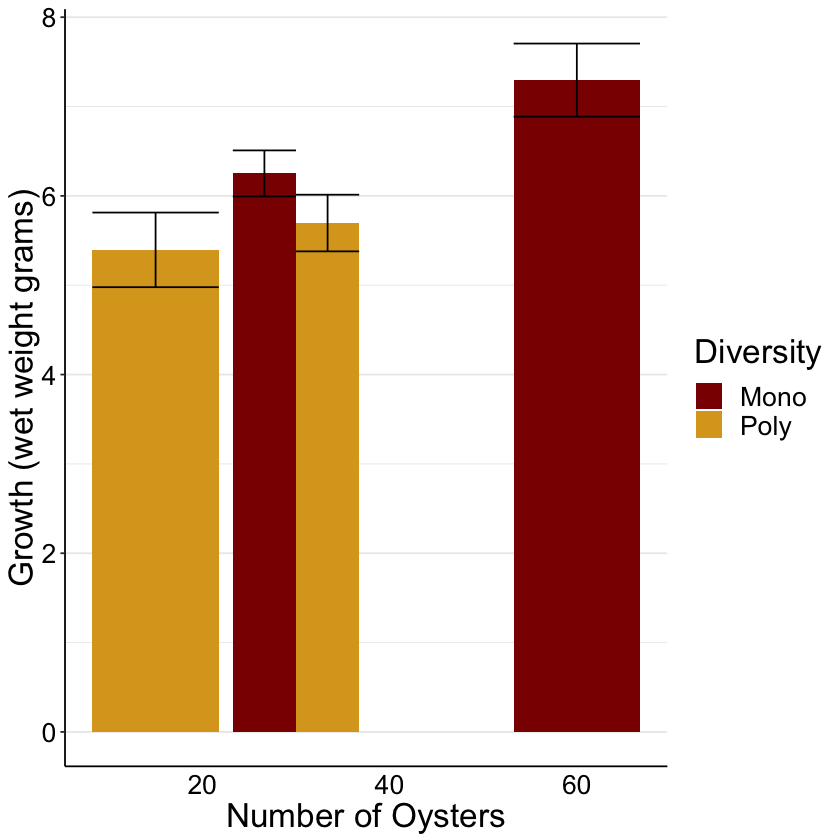

In [156]:
ggplot(weight, aes(x = cv_start, y = avg, fill=Diversity)) +
scale_fill_manual(values=c("darkred", "goldenrod"))+
        geom_bar(stat="identity", position="dodge")+
 geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), position="dodge") +
theme_bw()+
 theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), axis.text=element_text(color="black"),
          text = element_text(size=20))+
ylab("Growth (wet weight grams)")+
xlab("Number of Oysters")

In [160]:
wc_cv_results= lme(Length_change ~ Length_pre+cv_start*Diversity, random=~1|Bucket, cv, method="REML")
summary(wc_cv_results)

Linear mixed-effects model fit by REML
 Data: cv 
       AIC      BIC   logLik
  2706.359 2734.557 -1346.18

Random effects:
 Formula: ~1 | Bucket
        (Intercept) Residual
StdDev:    1.344233 5.797286

Fixed effects: Length_change ~ Length_pre + cv_start * Diversity 
                          Value Std.Error  DF    t-value p-value
(Intercept)            33.51844 2.1016279 384  15.948798  0.0000
Length_pre             -0.89321 0.0400743 384 -22.288837  0.0000
cv_start                0.12925 0.0346829  31   3.726676  0.0008
DiversityPoly           5.12486 2.3596571  31   2.171865  0.0376
cv_start:DiversityPoly -0.14736 0.0773057  31  -1.906150  0.0659
 Correlation: 
                       (Intr) Lngth_ cv_str DvrstP
Length_pre             -0.623                     
cv_start               -0.682 -0.091              
DiversityPoly          -0.459 -0.138  0.671       
cv_start:DiversityPoly  0.278  0.086 -0.453 -0.903

Standardized Within-Group Residuals:
       Min         Q1        M

# Look at just final weight, same trends?

In [161]:
weightp=aggregate(Weight_post~Density+Diversity, data=cv, FUN=multi)
weightp$avg=weightp$Weight_post[,1]
weightp$sd=weightp$Weight_post[,2]
weightp=weightp[-3]


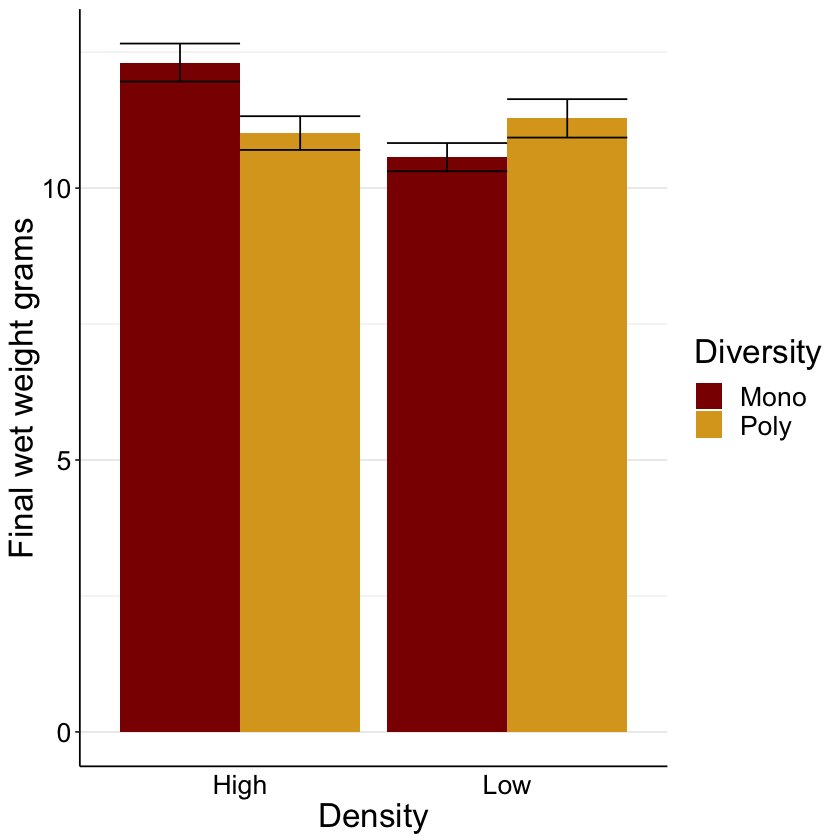

In [162]:
ggplot(weightp, aes(x = Density, y = avg, fill=Diversity)) +
scale_fill_manual(values=c("darkred", "goldenrod"))+
        geom_bar(stat="identity", position="dodge")+
 geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), position="dodge") +
theme_bw()+
 theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), axis.text=element_text(color="black"),
          text = element_text(size=20))+
ylab("Final wet weight grams")

Nope, so thats why we didnt see anything from the field experiment! 

# Change in length?

In [163]:
length=aggregate(Length_change~Density+Diversity, data=cv, FUN=multi)
length$avg=length$Length_change[,1]
length$sd=length$Length_change[,2]
length=length[-3]

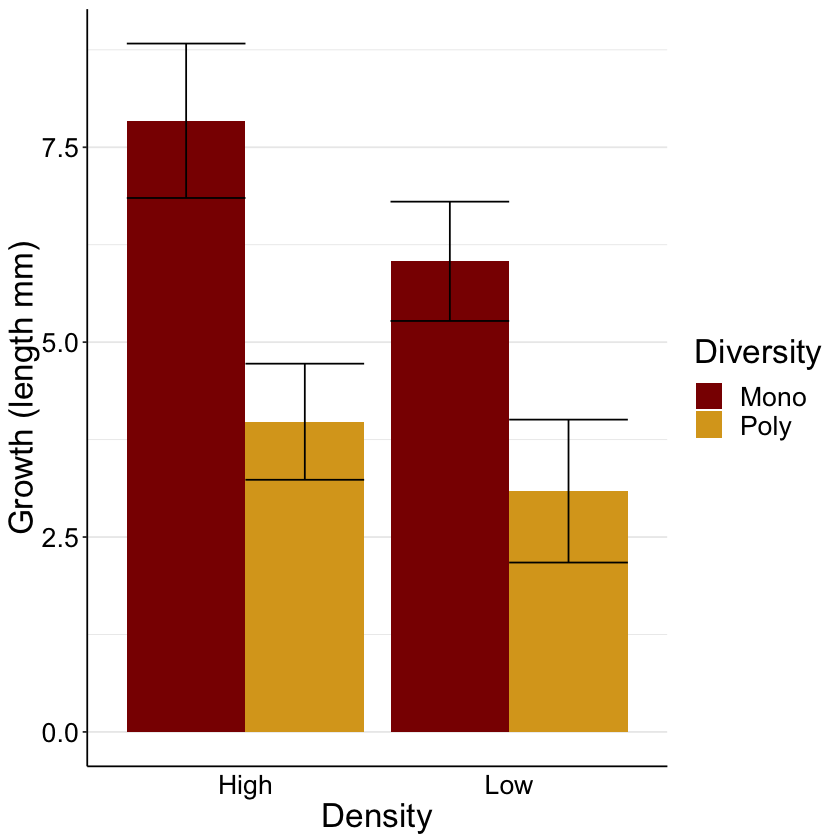

In [164]:
ggplot(length, aes(x = Density, y = avg, fill=Diversity)) +
scale_fill_manual(values=c("darkred", "goldenrod"))+
        geom_bar(stat="identity", position="dodge")+
 geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), position="dodge") +
theme_bw()+
 theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), axis.text=element_text(color="black"),
          text = element_text(size=20))+
ylab("Growth (length mm)")

Look at DOC, look at mussels

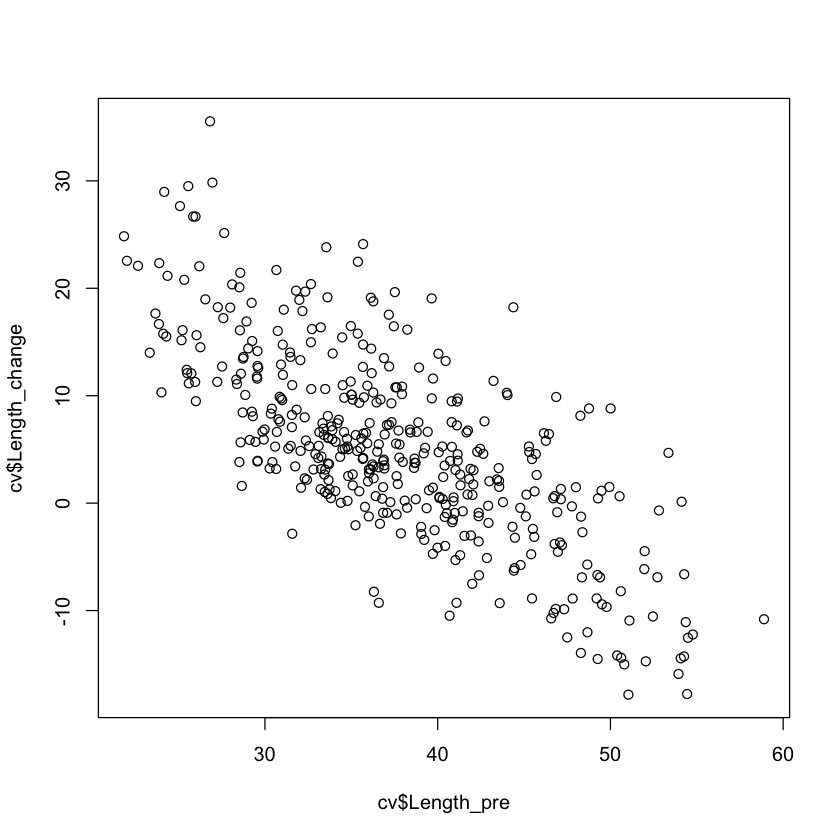

In [165]:
plot(cv$Length_pre, cv$Length_change)

In [166]:
lc_results= lme(fixed=Length_change ~ Density*Diversity+Length_pre, random=~1|Bucket, cv, method="REML")
summary(lc_results)

Linear mixed-effects model fit by REML
 Data: cv 
       AIC      BIC   logLik
  2694.141 2722.339 -1340.07

Random effects:
 Formula: ~1 | Bucket
        (Intercept) Residual
StdDev:    1.344233 5.797286

Fixed effects: Length_change ~ Density * Diversity + Length_pre 
                            Value Std.Error  DF    t-value p-value
(Intercept)              41.27355 1.6668413 384  24.761534  0.0000
DensityLow               -3.87755 1.0404860  31  -3.726676  0.0008
DiversityPoly            -3.17339 1.0167448  31  -3.121125  0.0039
Length_pre               -0.89321 0.0400743 384 -22.288837  0.0000
DensityLow:DiversityPoly  4.14912 1.4702237  31   2.822103  0.0083
 Correlation: 
                         (Intr) DnstyL DvrstP Lngth_
DensityLow               -0.388                     
DiversityPoly            -0.284  0.498              
Length_pre               -0.900  0.091 -0.032       
DensityLow:DiversityPoly  0.306 -0.711 -0.688 -0.100

Standardized Within-Group Residuals:
       Mi

everything is significant

In [168]:
lc_dd= lme(Length_change ~ DD+Length_pre, random=~1|Bucket, cv, method="REML")
summary(glht(lc_dd, linfct=mcp(DD="Tukey")))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lme.formula(fixed = Length_change ~ DD + Length_pre, data = cv, 
    random = ~1 | Bucket, method = "REML")

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)   
Low.Mono - High.Mono == 0   -3.8776     1.0405  -3.727  0.00104 **
High.Poly - High.Mono == 0  -3.1734     1.0167  -3.121  0.00970 **
Low.Poly - High.Mono == 0   -2.9018     1.0494  -2.765  0.02909 * 
High.Poly - Low.Mono == 0    0.7042     1.0305   0.683  0.90347   
Low.Poly - Low.Mono == 0     0.9757     1.0674   0.914  0.79726   
Low.Poly - High.Poly == 0    0.2716     1.0339   0.263  0.99366   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)
